In [1]:
# system
import os

# scipy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# nutrig
import flt.tools as tools

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

%matplotlib inline

Welcome to JupyROOT 6.30/04


In [12]:
n_templates   = 96
corr_window   = [-10,10]
fit_window    = [-10,30]
pol           = 'XY'
n_pol         = len(pol)
dataset       = 'bias_test'
range_zenith  = [30.6,87.35]
range_omega   = [0.,2.]
n_bins_zenith = 10
n_bins_omega  = 10
rf_chain    = 'rfv2'

param_str = f'templates_{n_templates}_cw_{corr_window[0]}_{corr_window[1]}_fw_{fit_window[0]}_{fit_window[1]}'
title_str = f'{n_templates} templates, CW = [{corr_window[0]},{corr_window[1]}], FW = [{fit_window[0]},{fit_window[1]}]'

plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/plots'
savefig  = False

In [13]:
#bkg_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
bkg_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_bkg_dataset_nutrig_gp13_th1_55_th2_35_train_seed_300_{param_str}.npz' # 1 kHz

#sig_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results/results_template_FLT_{pol}_sig_dataset_nutrig_gp13_train_seed_300_{param_str}.npz'
sig_train_res_file = f'/sps/grand/pcorrea/nutrig/template/results_bias/results_template_FLT_{pol}_sig_dataset_{dataset}_bins_{n_bins_zenith}x{n_bins_omega}_zenith_{range_zenith[0]}_{range_zenith[1]}_omega_diff_{range_omega[0]}_{range_omega[1]}_seed_300_{param_str}.npz'

bkg_results = tools.load_results(bkg_train_res_file,n_pol)
sig_results = tools.load_results(sig_train_res_file,n_pol)

bkg_idx_template_best = np.take_along_axis(bkg_results['idx_template_best'],bkg_results['idx_pol'].astype(int)[:,None],axis=1)[:,0]
sig_idx_template_best = np.take_along_axis(sig_results['idx_template_best'],sig_results['idx_pol'].astype(int)[:,None],axis=1)[:,0]

input_template_file = f'/sps/grand/pcorrea/nutrig/template/lib/templates_{n_templates}_{pol}_{rf_chain}.npz'
input_metadata_file = f'/sps/grand/pcorrea/nutrig/template/lib/metadata_{n_templates}_{pol}_{rf_chain}.npz'

In [14]:
def get_relative_counts(idx_template_best,template_ids):
    template_idcs = np.arange( len(template_ids) )

    template_idcs_unique, template_rel_counts = np.unique(idx_template_best,return_counts=True)
    template_rel_counts                       = template_rel_counts/template_rel_counts.sum()

    for idx in template_idcs:
        if idx not in template_idcs_unique:
            template_idcs_unique = np.append(template_idcs_unique,idx)
            template_rel_counts  = np.append(template_rel_counts,0)

    sort_idcs = np.argsort(template_idcs_unique)
    return template_idcs_unique[sort_idcs], template_rel_counts[sort_idcs]

In [15]:
try:
    f = np.load(input_template_file)
    template_ids_input = f['template_ids']
except:
    template_ids_input = np.arange(n_templates)

bkg_template_idcs, bkg_template_rel_counts = get_relative_counts(bkg_idx_template_best,template_ids_input)
sig_template_idcs, sig_template_rel_counts = get_relative_counts(sig_idx_template_best,template_ids_input)

diff_counts = sig_template_rel_counts - bkg_template_rel_counts[sig_template_idcs]

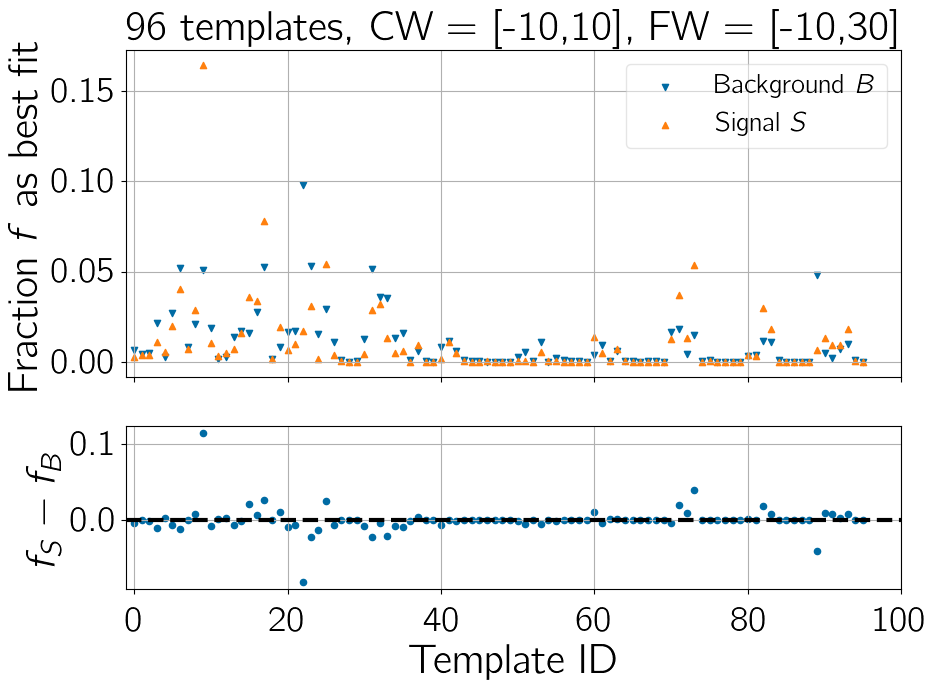

In [16]:
fig, ax = plt.subplots(2,1,height_ratios=[2,1],sharex=True)

ax[0].scatter(template_ids_input[bkg_template_idcs], bkg_template_rel_counts / 1., s=20, marker='v', label=r'Background $B$')
ax[0].scatter(template_ids_input[sig_template_idcs], sig_template_rel_counts / 1., s=20, marker='^', label=r'Signal $S$')


ax[1].scatter(template_ids_input[sig_template_idcs], diff_counts / 1., s=20)
ax[1].axhline(0,ls='--',color='k')

ax[0].set_title(title_str)
ax[0].set_xlim([-1,100])

# plt.xlabel('Best-fit template ID')
# plt.ylabel(r'$f_s - f_b$')

ax[1].set_xlabel('Template ID')
ax[0].set_ylabel(r'Fraction $f$ as best fit')
ax[1].set_ylabel(r'$f_S - f_B$')

ax[0].legend(fontsize=20,frameon=True,framealpha=.5)

if savefig:
    plot_name = 'best_temp_fraction_' + param_str
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )


plt.show()

In [79]:
template_ids_input

array([ 9, 17, 19, 72, 73])

In [80]:
np.where(diff_counts>0)[0].size

3

In [81]:
template_idcs_output = np.where(diff_counts>0)[0]
template_ids_output  = template_ids_input[template_idcs_output]
template_ids_output

array([ 9, 19, 72])

In [63]:
output_template_file = f'/sps/grand/pcorrea/nutrig/template/lib/templates_{len(template_ids_output)}_{pol}_{rf_chain}.npz'
output_metadata_file = f'/sps/grand/pcorrea/nutrig/template/lib/metadata_{len(template_ids_output)}_{pol}_{rf_chain}.npz'

In [64]:
f = np.load(input_template_file)

np.savez(output_template_file,
         templates=f['templates'][template_idcs_output],
         template_ids=template_ids_output)

f = np.load(input_metadata_file)

np.savez(output_metadata_file,
         energy     = f['energy'][template_idcs_output],
         zenith     = f['zenith'][template_idcs_output],
         azimuth    = f['azimuth'][template_idcs_output],
         omega      = f['omega'][template_idcs_output],
         omega_c    = f['omega_c'][template_idcs_output],
         omega_diff = f['omega_diff'][template_idcs_output],
         vf         = f['vf'][template_idcs_output],
         du_idx     = f['du_idx'][template_idcs_output])

energy     = f['energy']
zenith     = f['zenith']
azimuth    = f['azimuth']
omega      = f['omega']
omega_c    = f['omega_c']
omega_diff = f['omega_diff']
vf         = f['vf']
du_idx     = f['du_idx']

In [83]:
165/3

55.0